In [3]:
import warnings 
warnings.filterwarnings("ignore")

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.stats
from matplotlib import container

In [5]:
summary_df = pd.read_csv("aggregate_summary_all.csv", index_col=0)

N_mols = [450, 600, 900, 1800]
ensembles = ["NPT-exsmall", "NPT-small", "NPT-medium", "NPT-large"]

mol_ensemble_conversion = dict()
for mol, ensemble in zip(N_mols, ensembles):
    mol_ensemble_conversion[ensemble] = mol
    
summary_df["liqN"] = [mol_ensemble_conversion[ensemble]
                      for ensemble in summary_df["ensemble"]]

molecules = summary_df["molecule"]
molecule_set = set(molecules)
group_key = "molecule"
g_list = list()

In [6]:
plt.rcParams["font.family"] = "helvetica"


# Data cleaning and intial set up

In [7]:
def mean_confidence_interval(m,se, confidence=0.95):  
    se = np.array(se)
    n = 16
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

In [8]:
from pprint import pprint

def data_cleaning(molecule_set):
    """Make sure properties of all molecule in the provided molecule_set has been calculated."""
    for molecule in molecule_set:
        try:
            mol_group = summary_df.groupby(group_key)
            mol_df = mol_group.get_group(molecule)
        except KeyError:
            print(f"skipping: {molecule}, no data available.")
            continue
        mol_df["statepoint"] = (
            summary_df["temperature"].map(str)
            + "K, "
            + summary_df["pressure"].map(str)
            + "kPa, "
            + summary_df["ensemble"]
        )
        sp_set = set(mol_df["statepoint"])
        goods = list()
        bads = list()
        for engine in mol_df["engine"].unique():
            found_sp = mol_df[mol_df["engine"] == engine].index.tolist()
            if len(found_sp) == len(set(mol_df["statepoint"])):
                goods.append((engine, found_sp))
            else:
                mol_df.drop(axis=0, labels=found_sp, inplace=True)
                bads.append((engine, found_sp))
        print(molecule)
        if goods:
            print(f"\tPassed: {[good[0] for good in goods]}")
        if bads:
            print(f"\tFailed: {[bad[0] for bad in bads]}")
data_cleaning(molecule_set)

methaneUA
	Passed: ['lammps-VU', 'mcccs']


# Style set up

In [9]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)


In [10]:
moleculed = ("ethaneAA",)
engines = ("lammps-VU", "mcccs",)


# Colors
symbols = {}
symbols["cassandra"] = "o"
symbols[ "mcccs"] = "^"
symbols["gomc"] = "s"
symbols["gromacs"] = "x" 
symbols[ "hoomd"] = "v" 
symbols[ "lammps-VU"] = "D"
#symbols[ "LAMMPS-UD"] = ">"

colors = {}
colors["cassandra"] = "#009392" #(23/256, 109/256, 156/256)
colors["mcccs"] = "#39B1B5" #(194/256, 135/256, 32/256)
colors["gomc"] = "#9CCB86" #(21/256, 138/256, 106/256)
colors["gromacs"] = "#E9E29C" #(186/256, 97/256, 26/256)
colors["hoomd"] = "#EEB479" #(193/256, 130/256, 181/256)
colors["lammps-VU"] = "#E88471" #(188/256, 146/256, 110/256)
colors["fix"] = "#40AD5A"
colors["flex"] = "#3C93C2"
# colors_dict = {all_engine_molecule: all_engine_colors, 
#                pentane_fixed: pentane_fixed_colors,
#                pentane_flexible: pentane_flexible_colors}

pretty_names = {
    "mcccs": "MCCCS-MN", 
    "lammps-VU": "LAMMPS",
}
figsize = (9, 6)

# Deviation plots

In [11]:
def create_deviation_plots(molecules, engines, figsize):
    for molecule in molecules:
        fig, ax = plt.subplots(figsize=figsize)
        try:
            mol_group = summary_df.groupby(group_key)
            mol_df = mol_group.get_group(molecule)
        except KeyError:
            print(f"skipping: {molecule}, no data available.")
            continue
            
        mol_df["statepoint"] = (
            summary_df["liqN"].map(str)
            + "\n"
            + summary_df["temperature"].map(str)
            + "K, "
            + summary_df["pressure"].map(str)
            + "kPa"
            )
        mol_df.sort_values(by="liqN", inplace=True)

        statepoints = list(set(mol_df["statepoint"]))
        statepoints_overall_means = list()
        xticks = list()
        sps_positions = list()
        for n_statepoint, statepoint in enumerate(statepoints):
            densities = list()
            stds = list()
            sems = list()
            Ns = list()
            for engine in engines:
                shortlisted = mol_df[
                    (mol_df["engine"]==engine)
                  & (mol_df["statepoint"]==statepoint)]
                densities.append(shortlisted["density-avg"])
                stds.append(shortlisted["density-std"])
                sems.append(shortlisted["density-sem"])
                Ns.append(shortlisted["liqN"])
            overall_mean = np.mean(densities)
            statepoints_overall_means.append(overall_mean)

            confidence_interval = mean_confidence_interval(densities, np.array(sems), confidence=0.95)
            percentage_delta_density = (densities-overall_mean) * 100 / overall_mean
            percentage_sem_density = 100 * np.array(sems) / overall_mean
            percentage_ci_density = 100 * np.array(confidence_interval) / overall_mean

            ind = list()
            sp_position = list()
            for i, engine in enumerate(engines): 
                ind.append(i)
                #sp_position.append(1*n_statepoint + 0.1*i)
                sp_position.append(Ns[i])
                ax.errorbar(
                     #1*n_statepoint + 0.1*i,
                     Ns[i],
                     percentage_delta_density[i],  
                     marker=symbols[engine],
                     yerr=percentage_ci_density[i],
                     color=colors[engine], 
                     ls='',
                     label=engine,
                    )

            sps_positions.append(np.mean(sp_position))
            xticks.append(statepoint+r'$\rho_{\mathrm{ave}}$'+r'$ = {:.4f}$'.format(overall_mean))
        ax.set_xlabel(r"N")
        ax.set_ylabel(r"$\frac{100\times\Delta\rho}{\rho}$")
        ax.tick_params(axis='y')
        #plt.title(f"{molecule}")
        props = dict(boxstyle='round', facecolor='none',alpha=1, ec = 'grey')
        #string+='{:.5f}'.format(overall_mean)

        ax.set_xticks([pos for pos in sps_positions])    
        # ax.set_xticklabels([
        #     f'{sp}\n' +r'$\rho_{\mathrm{ave}}$'+'$ = {:.4f}$'.format(sp_omean) 
        #     for sp_omean, sp in zip(statepoints_overall_means, statepoints)
        #     ]
        # )

        # Handle ylim 
        low, high = ax.get_ylim()
        bound = max(abs(low), abs(high))
        ax.set_ylim(-bound*1.1, bound*1.1) 
        
        # get handles
        #wrap_labels(ax, 10)
        handles, labels = ax.get_legend_handles_labels()
        
        #Sorting handles and labels: 
        labels_handles = dict()
        for handle, label in zip(handles, labels):
            labels_handles[label] = handle
        sorted_handles = [labels_handles[engine] for engine in engines]
        sorted_labels = [pretty_names[engine] for engine in engines]
        plt.legend(sorted_handles, 
                   sorted_labels,
                   facecolor='white', 
                   loc ='best',
                   ncol=2,
                   prop={'size': 12})
        #wrap_labels(ax, 10)
        plt.tight_layout()
        plt.grid(alpha = 0., axis='x')
        plt.savefig(f"{molecule}_deviation.pdf", dpi=500)
        plt.show()
        plt.close()

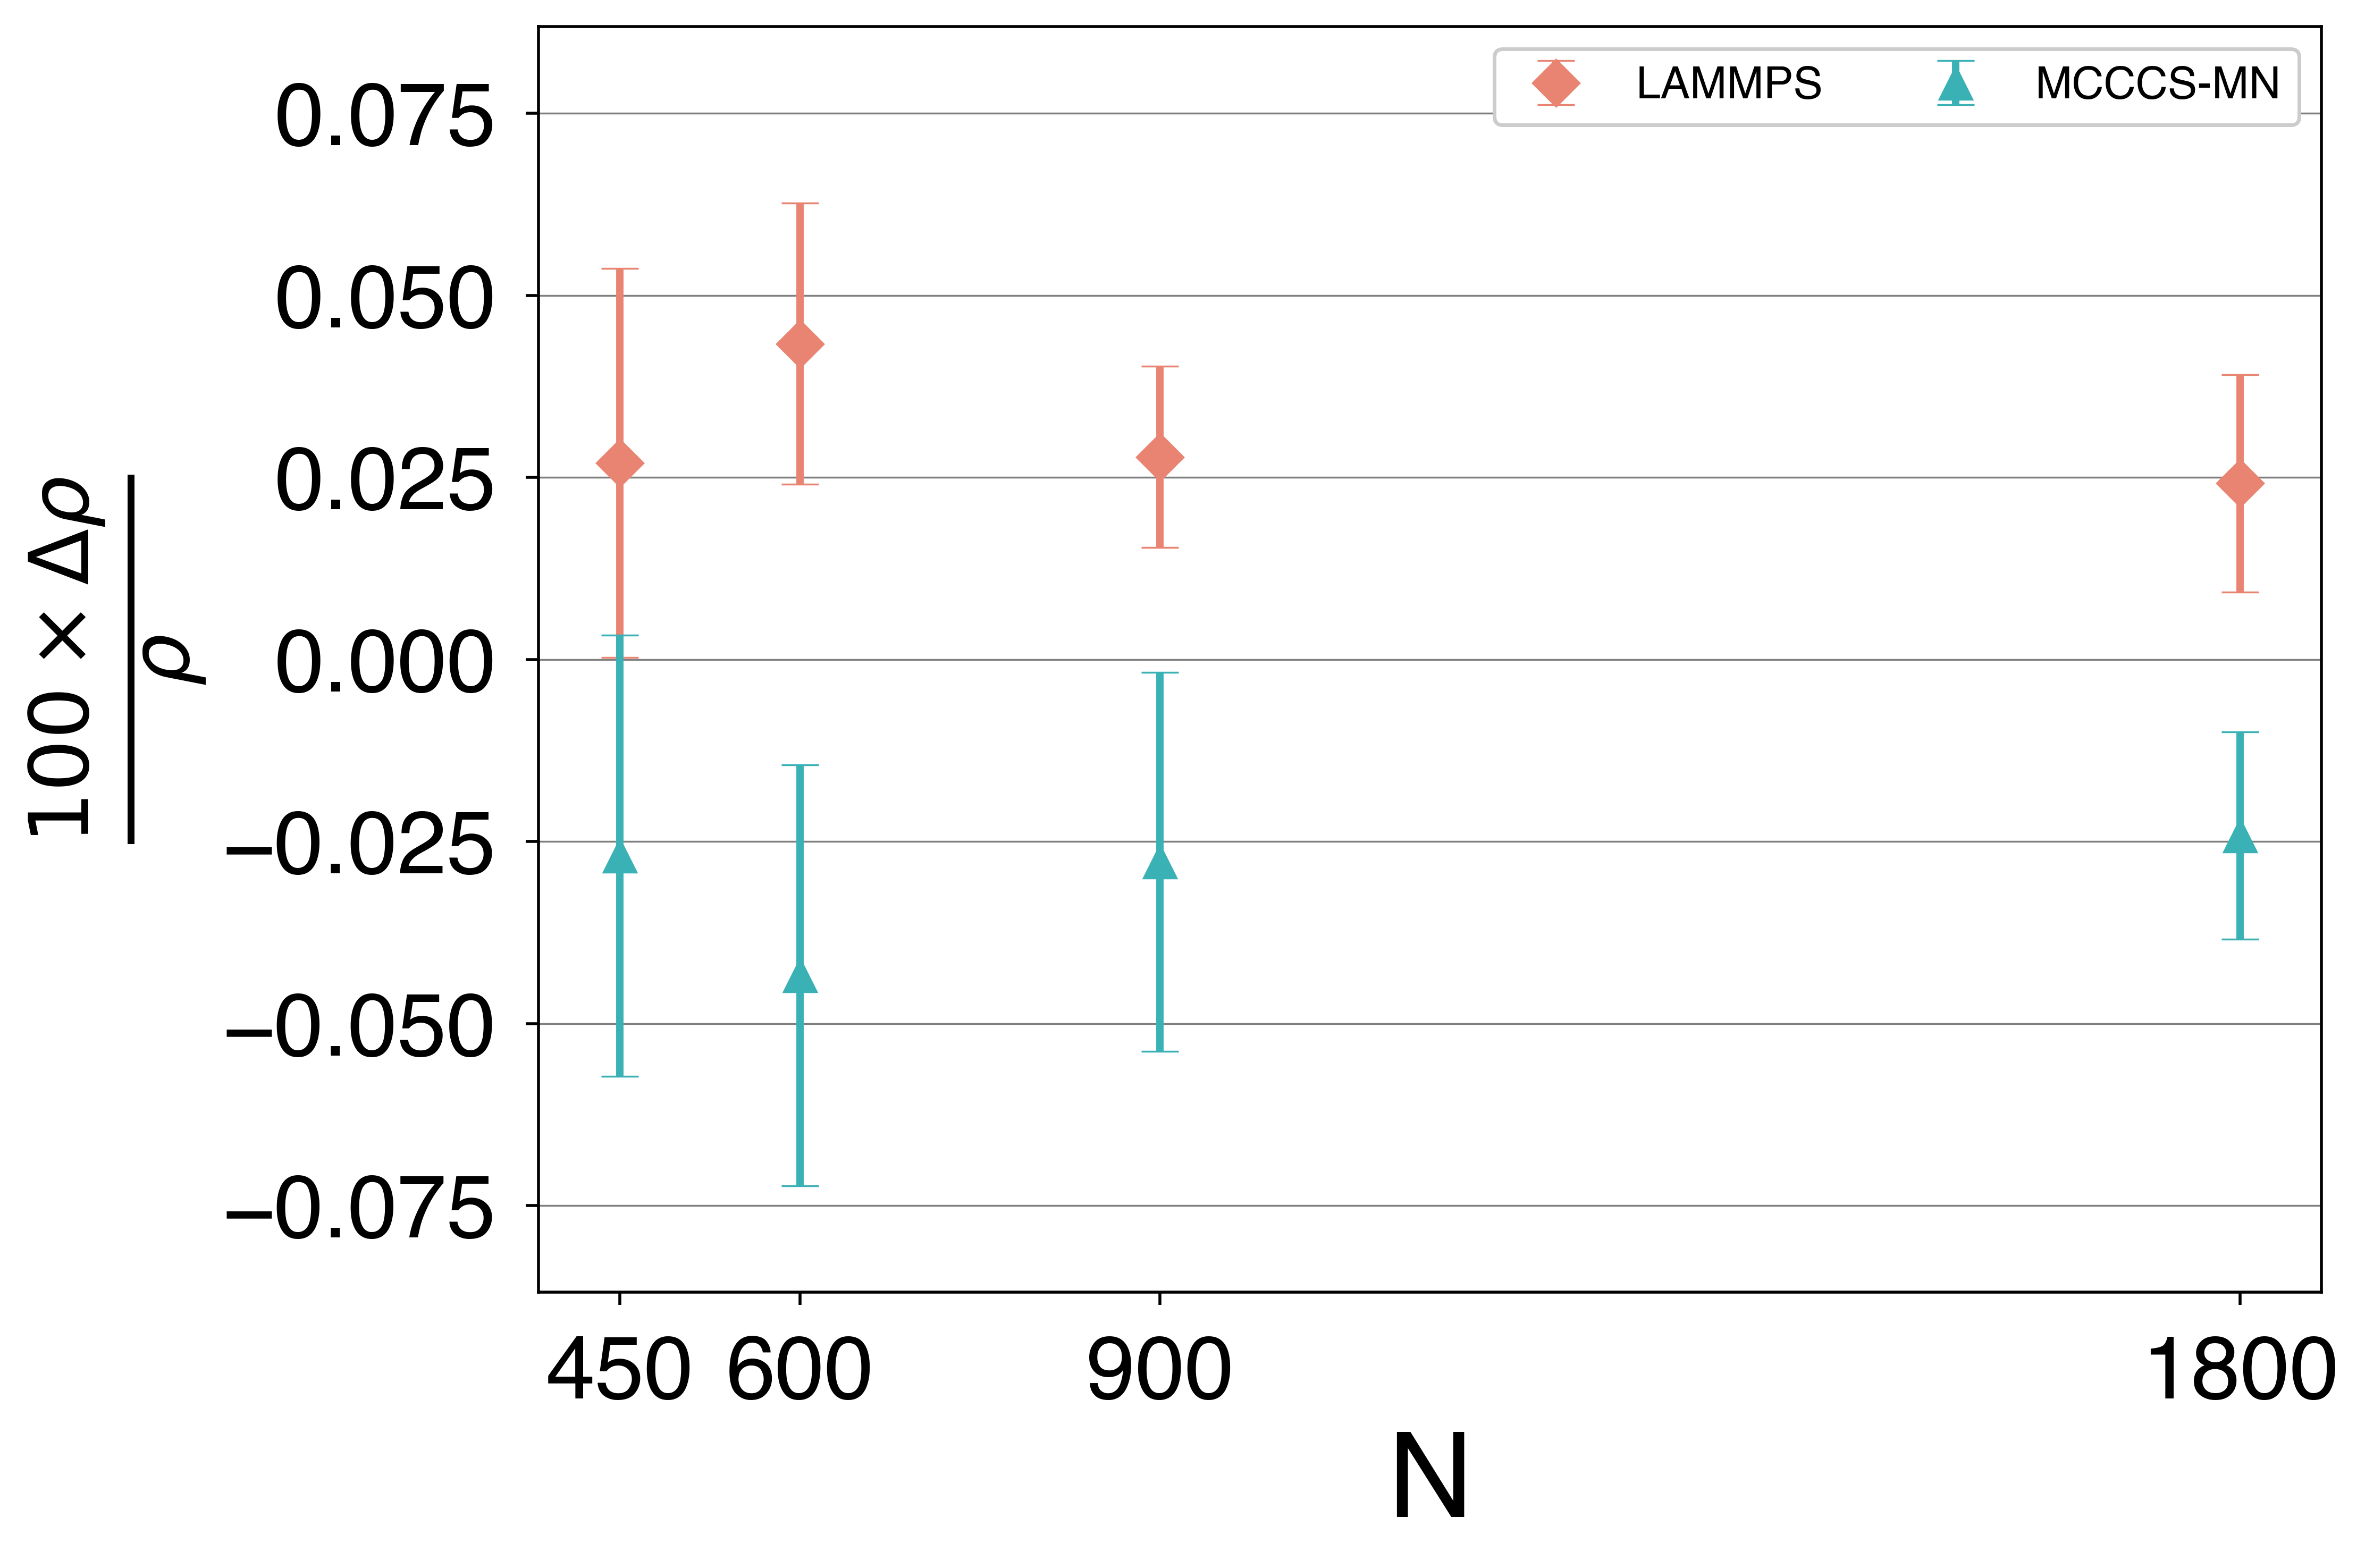

In [12]:
create_deviation_plots(molecule_set, engines, figsize)

# Density STD plots

In [13]:
def create_density_with_2std_plots(molecules, engines, figsize):
    for molecule in molecules:
        fig, ax = plt.subplots(figsize=figsize)
        try:
            mol_group = summary_df.groupby(group_key)
            mol_df = mol_group.get_group(molecule)
        except KeyError:
            print(f"skipping: {molecule}, no data available.")
            continue
            
        mol_df["statepoint"] = (
            summary_df["liqN"].map(str)
            + "\n"
            + summary_df["temperature"].map(str)
            + "K, "
            + summary_df["pressure"].map(str)
            + "kPa"
            )
        mol_df.sort_values(by="liqN", inplace=True)

        statepoints = list(set(mol_df["statepoint"]))
        statepoints_overall_means = list()

        xticks = list()
        sps_positions = list()
        for n_statepoint, statepoint in enumerate(statepoints):
            densities = list()
            stds = list()
            sems = list()
            Ns = list()
            for engine in engines:
                shortlisted = mol_df[
                    (mol_df["engine"]==engine)
                  & (mol_df["statepoint"]==statepoint)]
                densities.append(shortlisted["density-avg"])
                stds.append(shortlisted["density-std"])
                sems.append(shortlisted["density-sem"])
                Ns.append(shortlisted["liqN"])
            overall_mean = np.mean(densities)
            statepoints_overall_means.append(overall_mean)

            ind = list()
            sp_position = list()
            for i, engine in enumerate(engines): 
                ind.append(i)
                #sp_position.append(1*n_statepoint + 0.1*i)
                sp_position.append(Ns[i])
                ax.errorbar(
                     #1*n_statepoint + 0.1*i,
                     Ns[i],
                     densities[i],  
                     marker=symbols[engine],
                     yerr=stds[i],
                     color=colors[engine], 
                     ls='',
                     label=engine,
                    )

            sps_positions.append(np.mean(sp_position))
            xticks.append(statepoint+r'$\rho_{\mathrm{ave}}$'+r'$ = {:.4f}$'.format(overall_mean))
        ax.set_xlabel("N")
        ax.set_ylabel(r"$\frac{100\times\Delta\rho}{\rho}$")
        ax.tick_params(axis='y')
        #plt.title(f"{molecule}")
        props = dict(boxstyle='round', facecolor='none',alpha=1, ec = 'grey')
        #string+='{:.5f}'.format(overall_mean)

        ax.set_xticks([pos for pos in sps_positions])    
        # ax.set_xticklabels([
        #     f'{sp}\n' +r'$\rho_{\mathrm{ave}}$'+'$ = {:.4f}$'.format(sp_omean) 
        #     for sp_omean, sp in zip(statepoints_overall_means, statepoints)
        #     ]
        # )

        # Handle ylim 
        #low, high = ax.get_ylim()
        #bound = max(abs(low), abs(high))
        #ax.set_ylim(-bound*1.1, bound*1.1) 
        
        # get handles
        #wrap_labels(ax, 10)
        handles, labels = ax.get_legend_handles_labels()
        
        #Sorting handles and labels: 
        labels_handles = dict()
        for handle, label in zip(handles, labels):
            labels_handles[label] = handle
        sorted_handles = [labels_handles[engine] for engine in engines]
        sorted_labels = [pretty_names[engine] for engine in engines]
        plt.legend(sorted_handles, 
                   sorted_labels,
                   facecolor='white', 
                   loc ='best',
                   ncol=2,
                  prop={'size': 12})
        plt.tight_layout()
        plt.grid(alpha = 0., axis='x')
        plt.savefig(f"{molecule}_density_2stds.pdf", dpi=500)
        plt.show()
        plt.close()

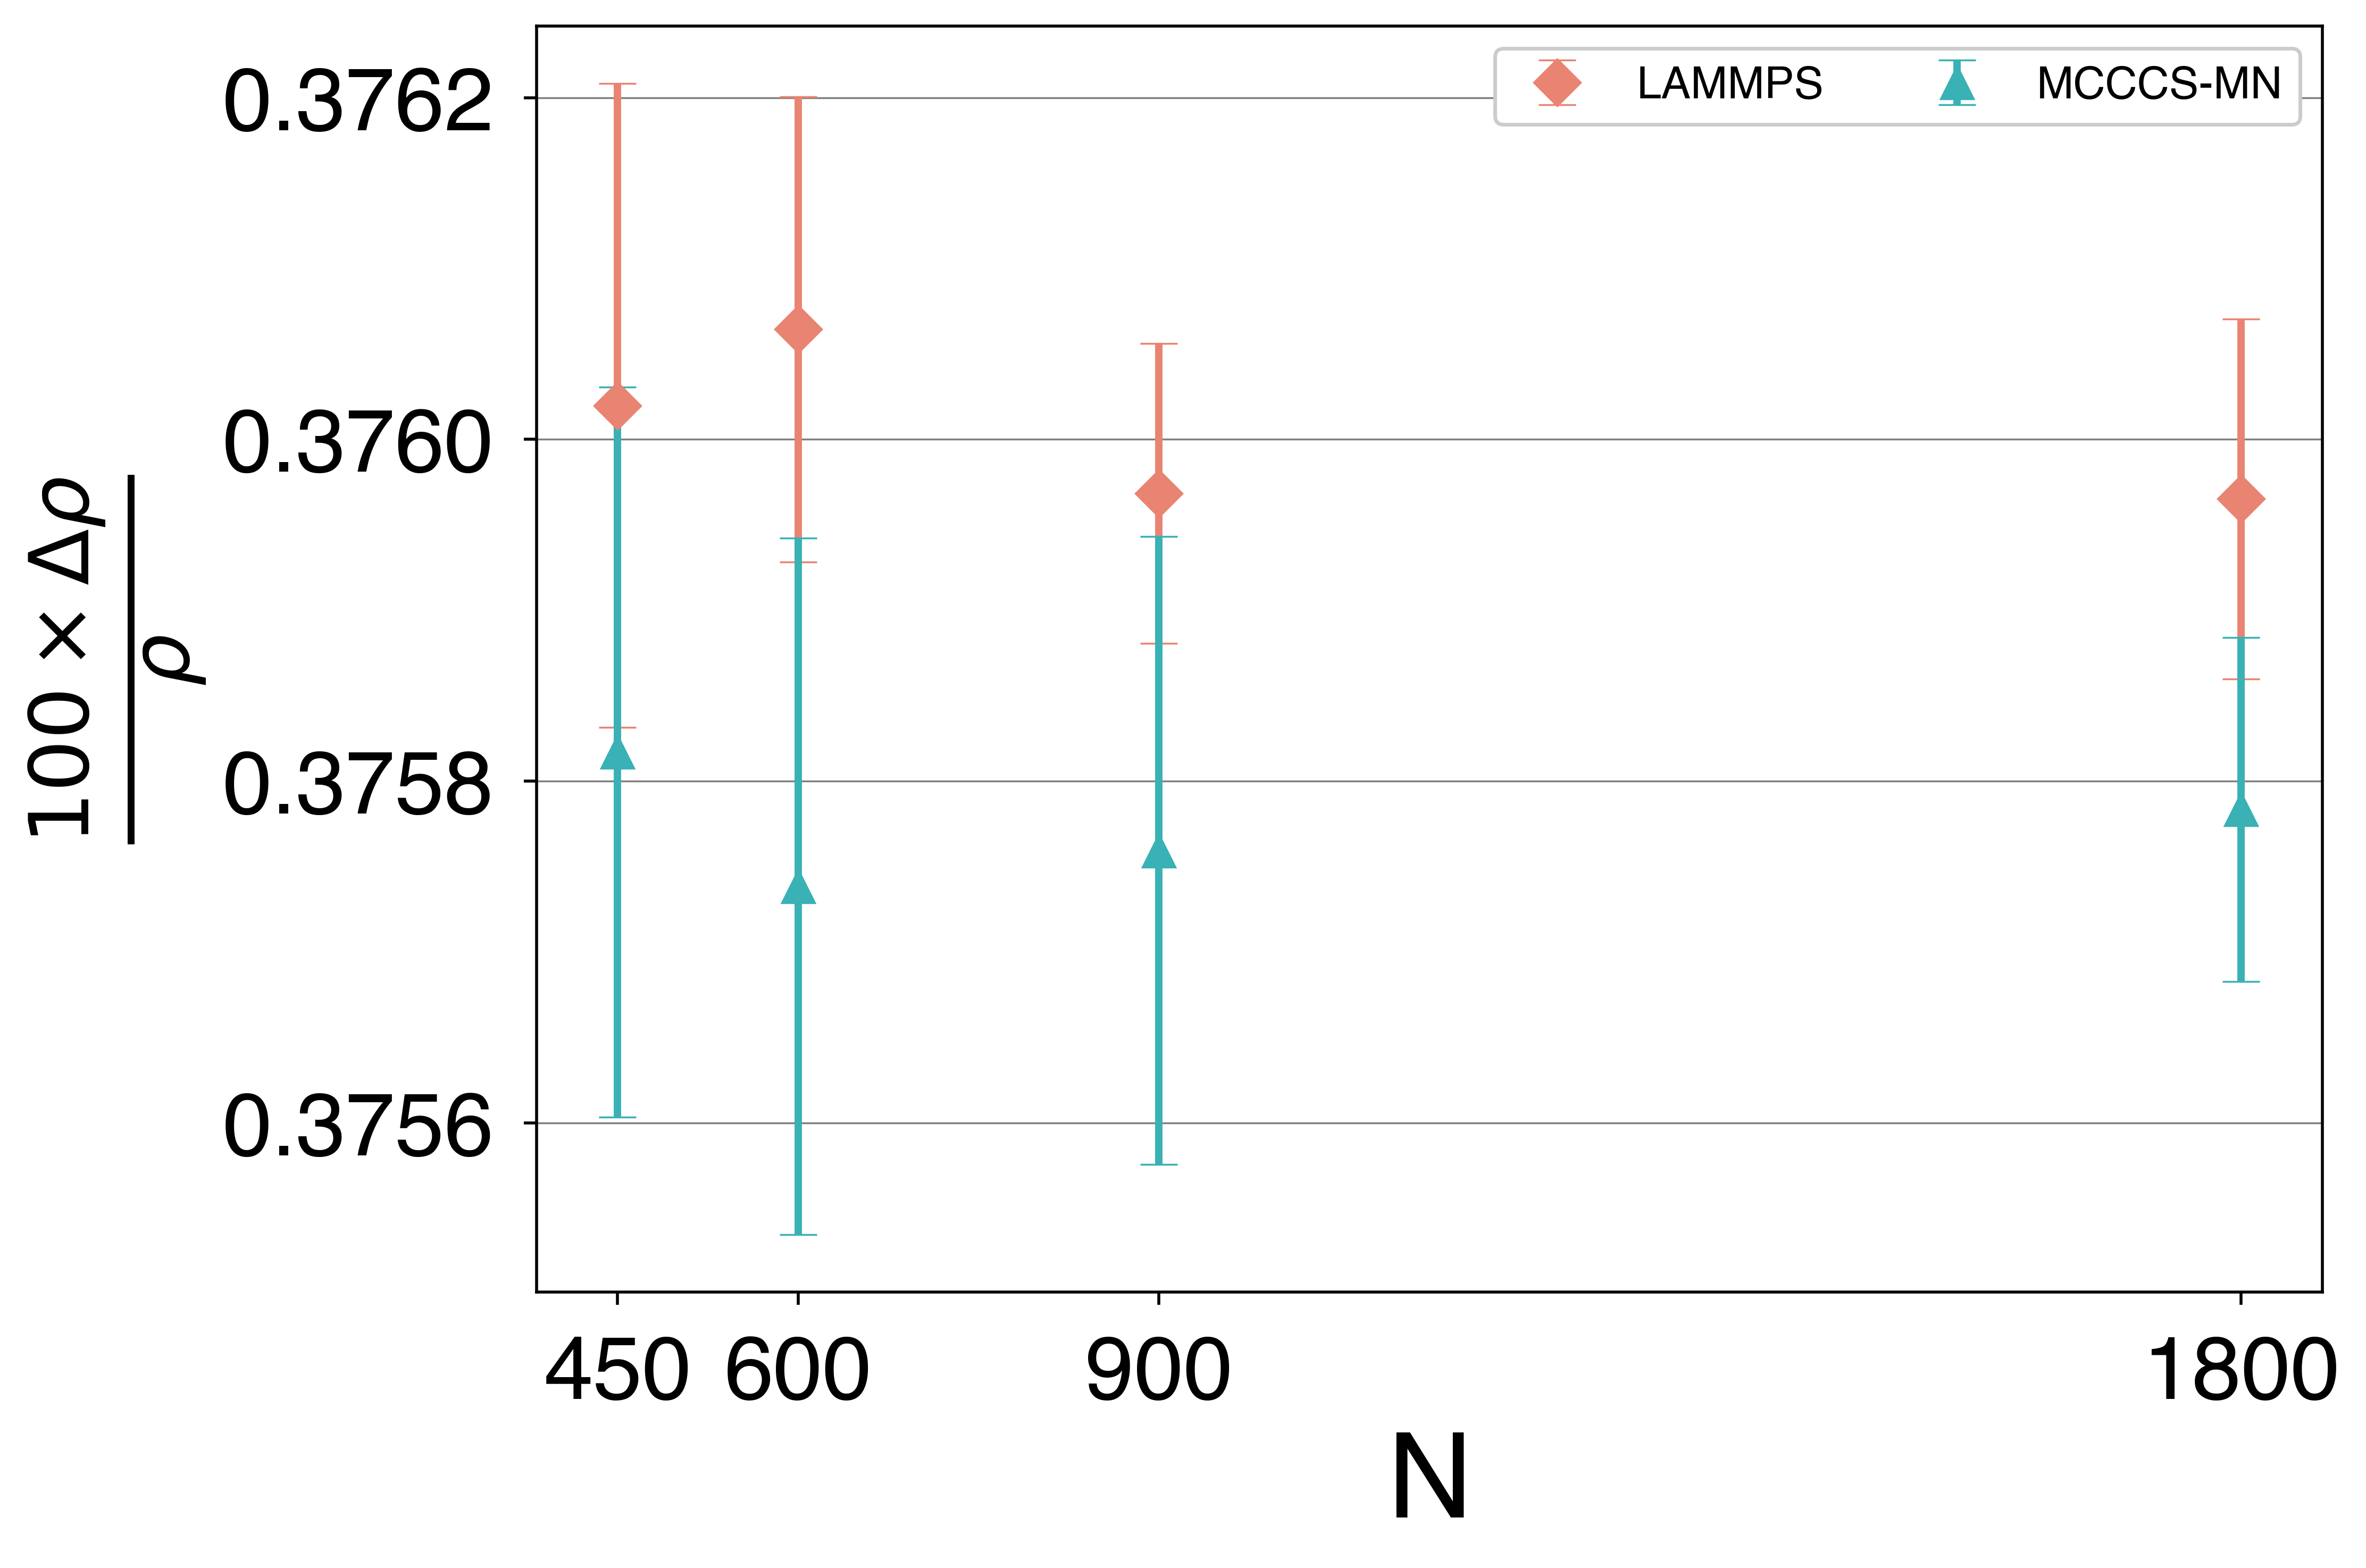

In [14]:
create_density_with_2std_plots(molecule_set, engines, figsize=figsize)

# Density SEM plot

In [15]:
def create_density_with_2sem_plots(molecules, engines, figsize):
    for molecule in molecules:
        fig, ax = plt.subplots(figsize=figsize)
        try:
            mol_group = summary_df.groupby(group_key)
            mol_df = mol_group.get_group(molecule)
        except KeyError:
            print(f"skipping: {molecule}, no data available.")
            continue
            
        mol_df["statepoint"] = (
            summary_df["liqN"].map(str)
            + "\n"
            + summary_df["temperature"].map(str)
            + "K, "
            + summary_df["pressure"].map(str)
            + "kPa"
            )
        mol_df.sort_values(by="liqN", inplace=True)

        statepoints = list(set(mol_df["statepoint"]))
        statepoints_overall_means = list()

        xticks = list()
        sps_positions = list()
        for n_statepoint, statepoint in enumerate(statepoints):
            densities = list()
            stds = list()
            sems = list()
            Ns = list()
            for engine in engines:
                shortlisted = mol_df[
                    (mol_df["engine"]==engine)
                  & (mol_df["statepoint"]==statepoint)]
                densities.append(shortlisted["density-avg"])
                stds.append(shortlisted["density-std"])
                sems.append(shortlisted["density-sem"])
                Ns.append(shortlisted["liqN"])
            overall_mean = np.mean(densities)
            statepoints_overall_means.append(overall_mean)

            ind = list()
            sp_position = list()
            for i, engine in enumerate(engines): 
                ind.append(i)
                #sp_position.append(1*n_statepoint + 0.1*i)
                sp_position.append(Ns[i])
                ax.errorbar(
                     #1*n_statepoint + 0.1*i,
                     Ns[i],
                     densities[i],  
                     marker=symbols[engine],
                     yerr=sems[i],
                     color=colors[engine], 
                     ls='',
                     label=engine,
                    )

            sps_positions.append(np.mean(sp_position))
            xticks.append(statepoint+r'$\rho_{\mathrm{ave}}$'+r'$ = {:.4f}$'.format(overall_mean))
        ax.set_xlabel("N")
        ax.set_ylabel(r"$\frac{100\times\Delta\rho}{\rho}$")
        ax.tick_params(axis='y')
        #plt.title(f"{molecule}")
        props = dict(boxstyle='round', facecolor='none',alpha=1, ec = 'grey')
        #string+='{:.5f}'.format(overall_mean)

        ax.set_xticks([pos for pos in sps_positions])    
        # ax.set_xticklabels([
        #     f'{sp}\n' +r'$\rho_{\mathrm{ave}}$'+'$ = {:.4f}$'.format(sp_omean) 
        #     for sp_omean, sp in zip(statepoints_overall_means, statepoints)
        #     ]
        # )

        # Handle ylim 
        #low, high = ax.get_ylim()
        #bound = max(abs(low), abs(high))
        #ax.set_ylim(-bound*1.1, bound*1.1) 
        
        # get handles
        #wrap_labels(ax, 10)
        handles, labels = ax.get_legend_handles_labels()
        
        #Sorting handles and labels: 
        labels_handles = dict()
        for handle, label in zip(handles, labels):
            labels_handles[label] = handle
        sorted_handles = [labels_handles[engine] for engine in engines]
        sorted_labels = [pretty_names[engine] for engine in engines]
        plt.legend(sorted_handles, 
                   sorted_labels,
                   facecolor='white', 
                   loc ='best',
                   ncol=2,
                  prop={'size': 12})
        plt.tight_layout()
        plt.grid(alpha = 0., axis='x')
        plt.savefig(f'{molecule}_density_2sems.pdf', dpi=500)
        plt.show()
        plt.close()

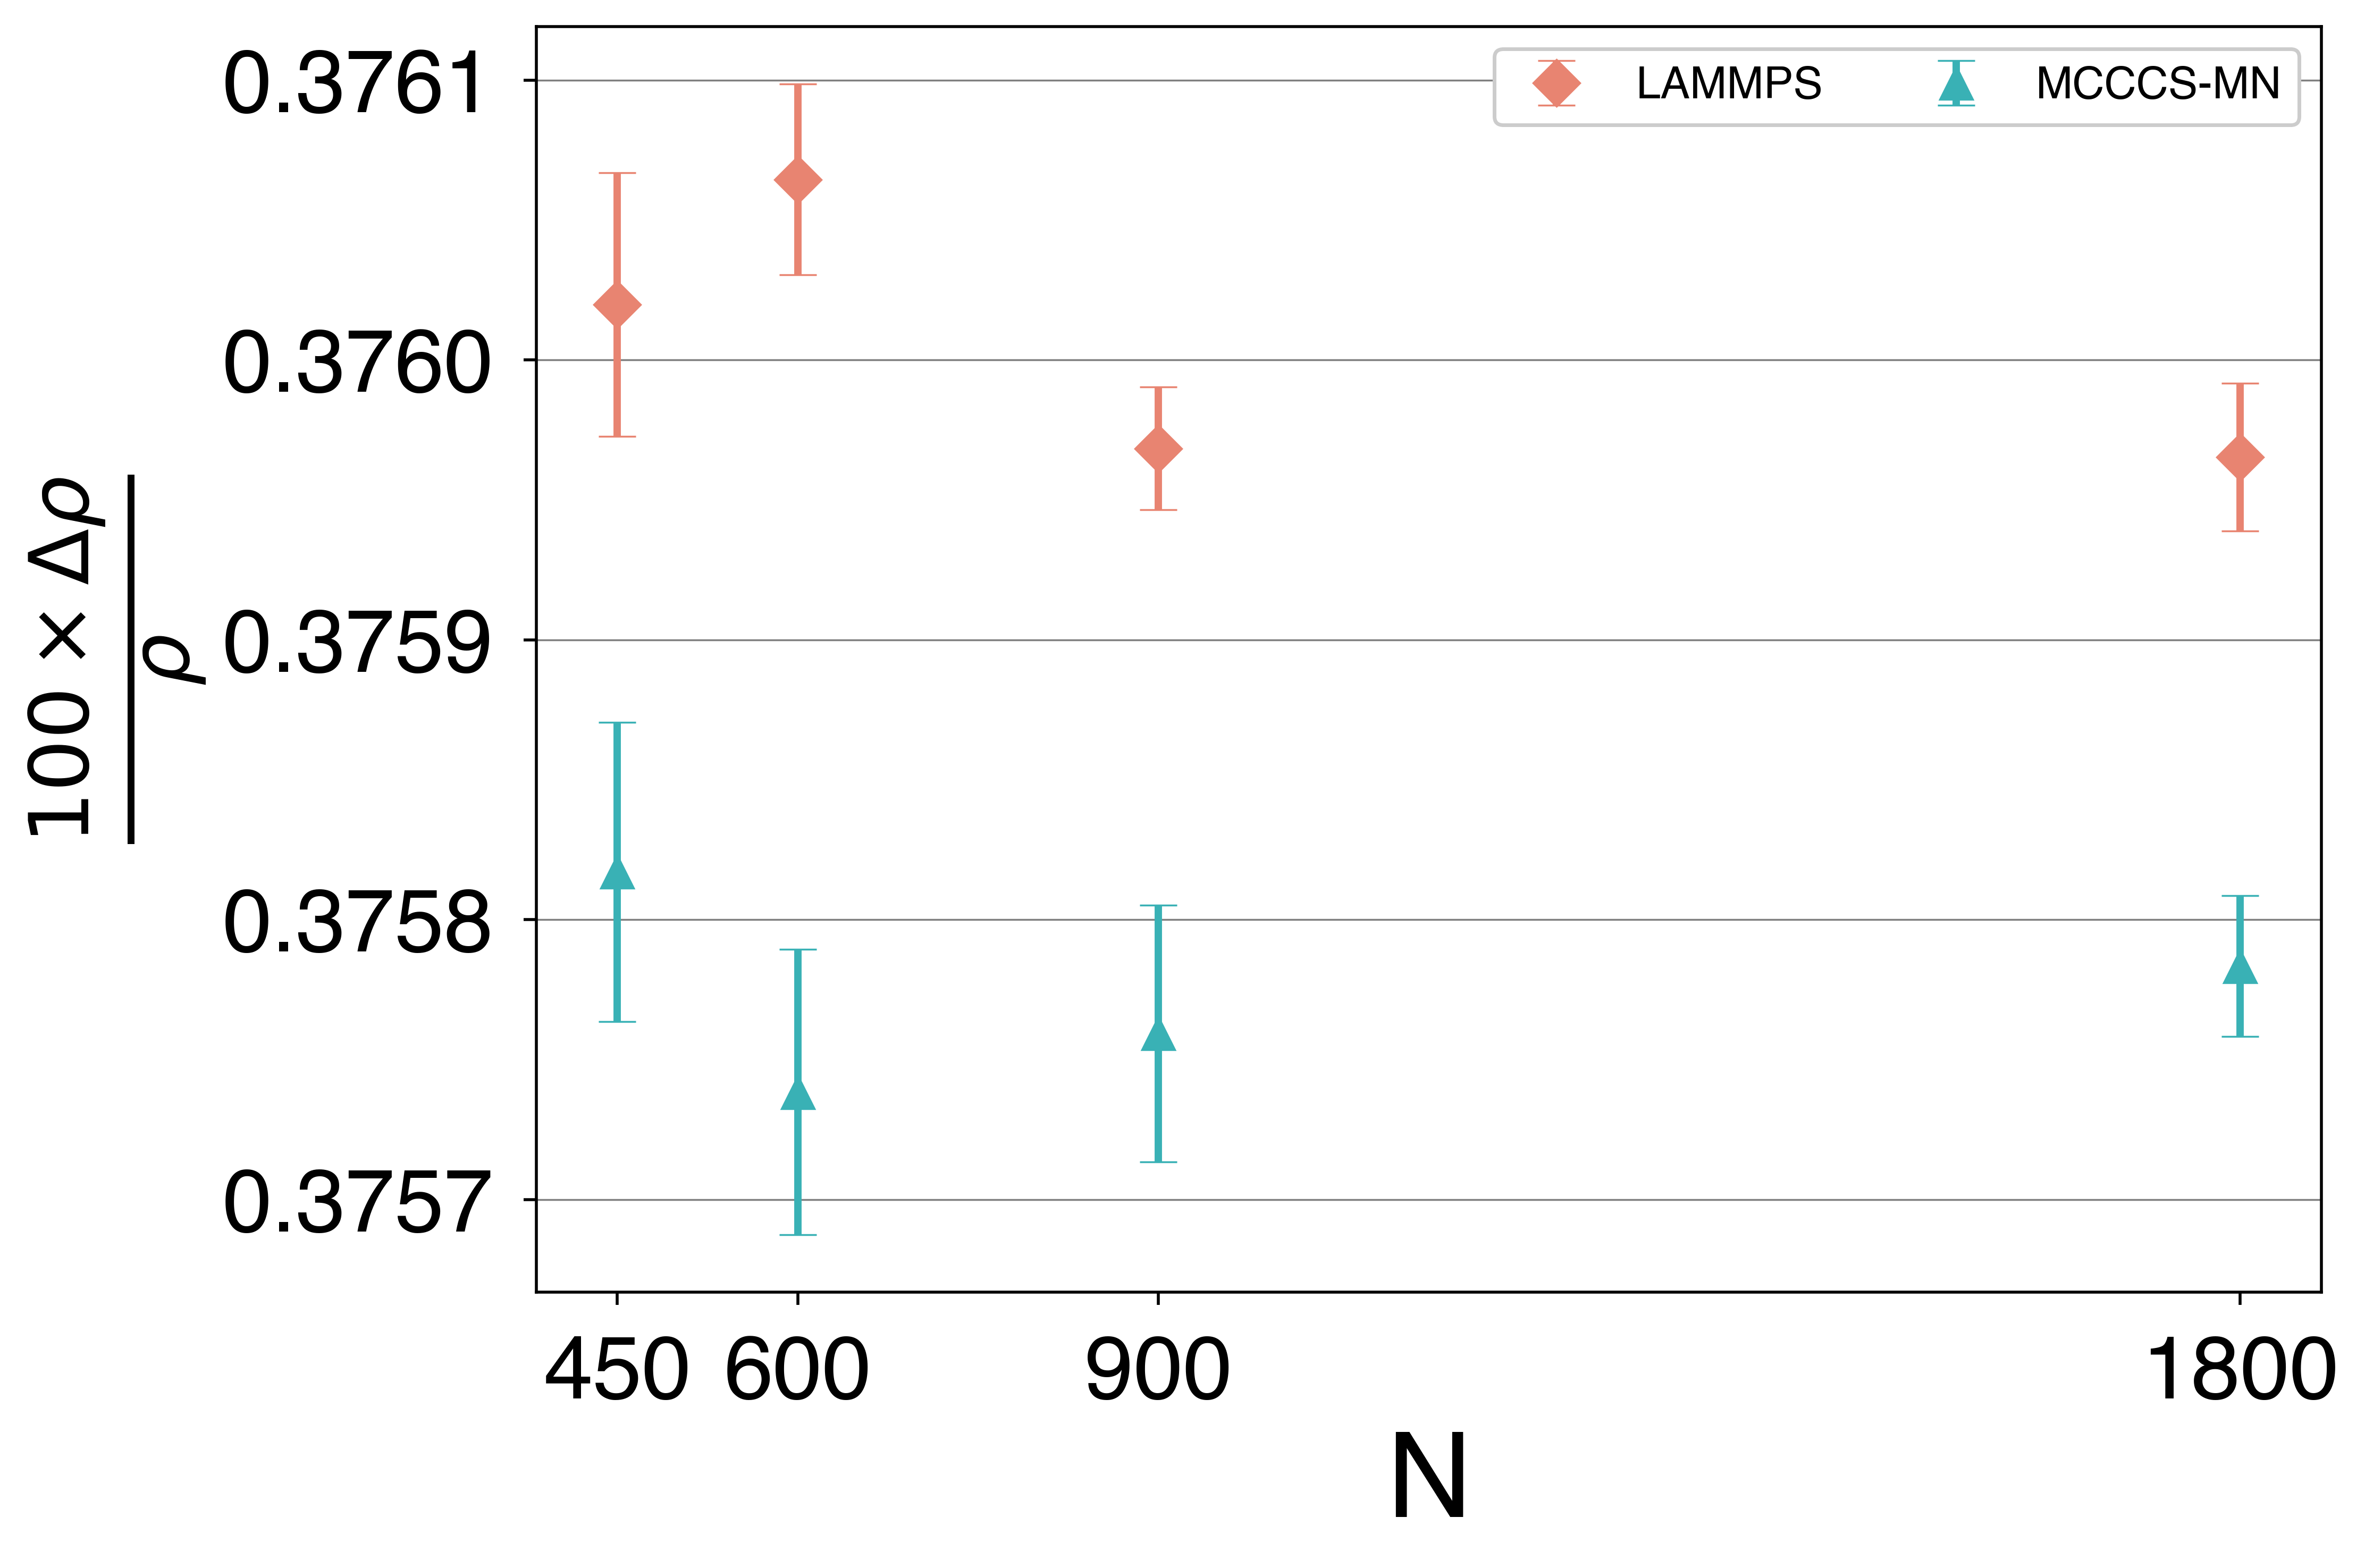

In [16]:
create_density_with_2sem_plots(molecule_set, engines, figsize)


In [38]:
def create_stacked_density_deviation_plots(molecules, engines, figsize):
    for molecule in molecules:
        # fig, ax = plt.subplots(figsize=figsize)
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(2, hspace=0)
        ax = gs.subplots(sharex=True, sharey=False)
        
        try:
            mol_group = summary_df.groupby(group_key)
            mol_df = mol_group.get_group(molecule)
        except KeyError:
            print(f"skipping: {molecule}, no data available.")
            continue
            
        mol_df["statepoint"] = (
            summary_df["liqN"].map(str)
            + "\n"
            + summary_df["temperature"].map(str)
            + "K, "
            + summary_df["pressure"].map(str)
            + "kPa"
            )
        mol_df.sort_values(by="liqN", inplace=True)

        statepoints = list(set(mol_df["statepoint"]))
        statepoints_overall_means = list()

        xticks = list()
        sps_positions = list()
        for n_statepoint, statepoint in enumerate(statepoints):
            densities = list()
            stds = list()
            sems = list()
            Ns = list()
            for engine in engines:
                shortlisted = mol_df[
                    (mol_df["engine"]==engine)
                  & (mol_df["statepoint"]==statepoint)]
                densities.append(shortlisted["density-avg"])
                stds.append(shortlisted["density-std"])
                sems.append(shortlisted["density-sem"])
                Ns.append(shortlisted["liqN"])
            overall_mean = np.mean(densities)
            statepoints_overall_means.append(overall_mean)

            confidence_interval = mean_confidence_interval(densities, np.array(sems), confidence=0.95)
            percentage_delta_density = (densities-overall_mean) * 100 / overall_mean
            percentage_sem_density = 100 * np.array(sems) / overall_mean
            percentage_ci_density = 100 * np.array(confidence_interval) / overall_mean
            
            ind = list()
            sp_position = list()
            for i, engine in enumerate(engines): 
                ind.append(i)
                #sp_position.append(1*n_statepoint + 0.1*i)
                sp_position.append(Ns[i])
                ax[0].errorbar(
                     #1*n_statepoint + 0.1*i,
                     Ns[i],
                     densities[i],  
                     marker=symbols[engine],
                     yerr=sems[i],
                     color=colors[engine], 
                     ls='',
                     label=engine,
                    )
                ax[1].errorbar(
                     #1*n_statepoint + 0.1*i, 
                     Ns[i],
                     percentage_delta_density[i],  
                     marker=symbols[engine],
                     yerr=percentage_ci_density[i],
                     color=colors[engine], 
                     ls='',
                     label=engine,
                    )
                
            sps_positions.append(np.mean(sp_position))
            xticks.append(statepoint+r'$\rho_{\mathrm{ave}}$'+r'$ = {:.4f}$'.format(overall_mean))

        ax[1].set_xlabel("N")
        ax[1].set_ylabel(r"$\frac{100\times\Delta\rho}{\rho}$")
        ax[0].set_ylabel(r"$\rho$  $[\frac{g}{cm^3}]$")
        
        ax[0].tick_params(axis='y')
        #plt.title(f"{molecule}")
        props = dict(boxstyle='round', facecolor='none',alpha=1, ec = 'grey')
        #string+='{:.5f}'.format(overall_mean)

        ax[0].set_xticks([pos for pos in sps_positions])    
        # ax.set_xticklabels([
        #     f'{sp}\n' +r'$\rho_{\mathrm{ave}}$'+'$ = {:.4f}$'.format(sp_omean) 
        #     for sp_omean, sp in zip(statepoints_overall_means, statepoints)
        #     ]
        # )

        # Handle ylim 
        low, high = ax[1].get_ylim()
        bound = max(abs(low), abs(high))
        ax[1].set_ylim(-bound*1.1, bound*1.1) 
        
        # get handles
        #wrap_labels(ax, 10)
        handles, labels = ax[1].get_legend_handles_labels()
        
        #Sorting handles and labels: 
        labels_handles = dict()
        for handle, label in zip(handles, labels):
            labels_handles[label] = handle
        sorted_handles = [labels_handles[engine] for engine in engines]
        sorted_labels = [pretty_names[engine] for engine in engines]
        plt.legend(sorted_handles, 
                   sorted_labels,
                   bbox_to_anchor=(1.01, 0.5),
                   bbox_transform=fig.transFigure,
                   labelspacing=2,
                   facecolor='white', 
                   loc='lower right',
                   prop={'size': 12},
                   ncol=1)
        
        plt.tight_layout()
        ax[0].grid(alpha = 0., axis='x')
        ax[1].grid(alpha = 0., axis='x')
        
        plt.savefig(f'figures/{molecule}_stacked_deviation_density.pdf', dpi=500, bbox_inches="tight")
        plt.show()
        plt.close()

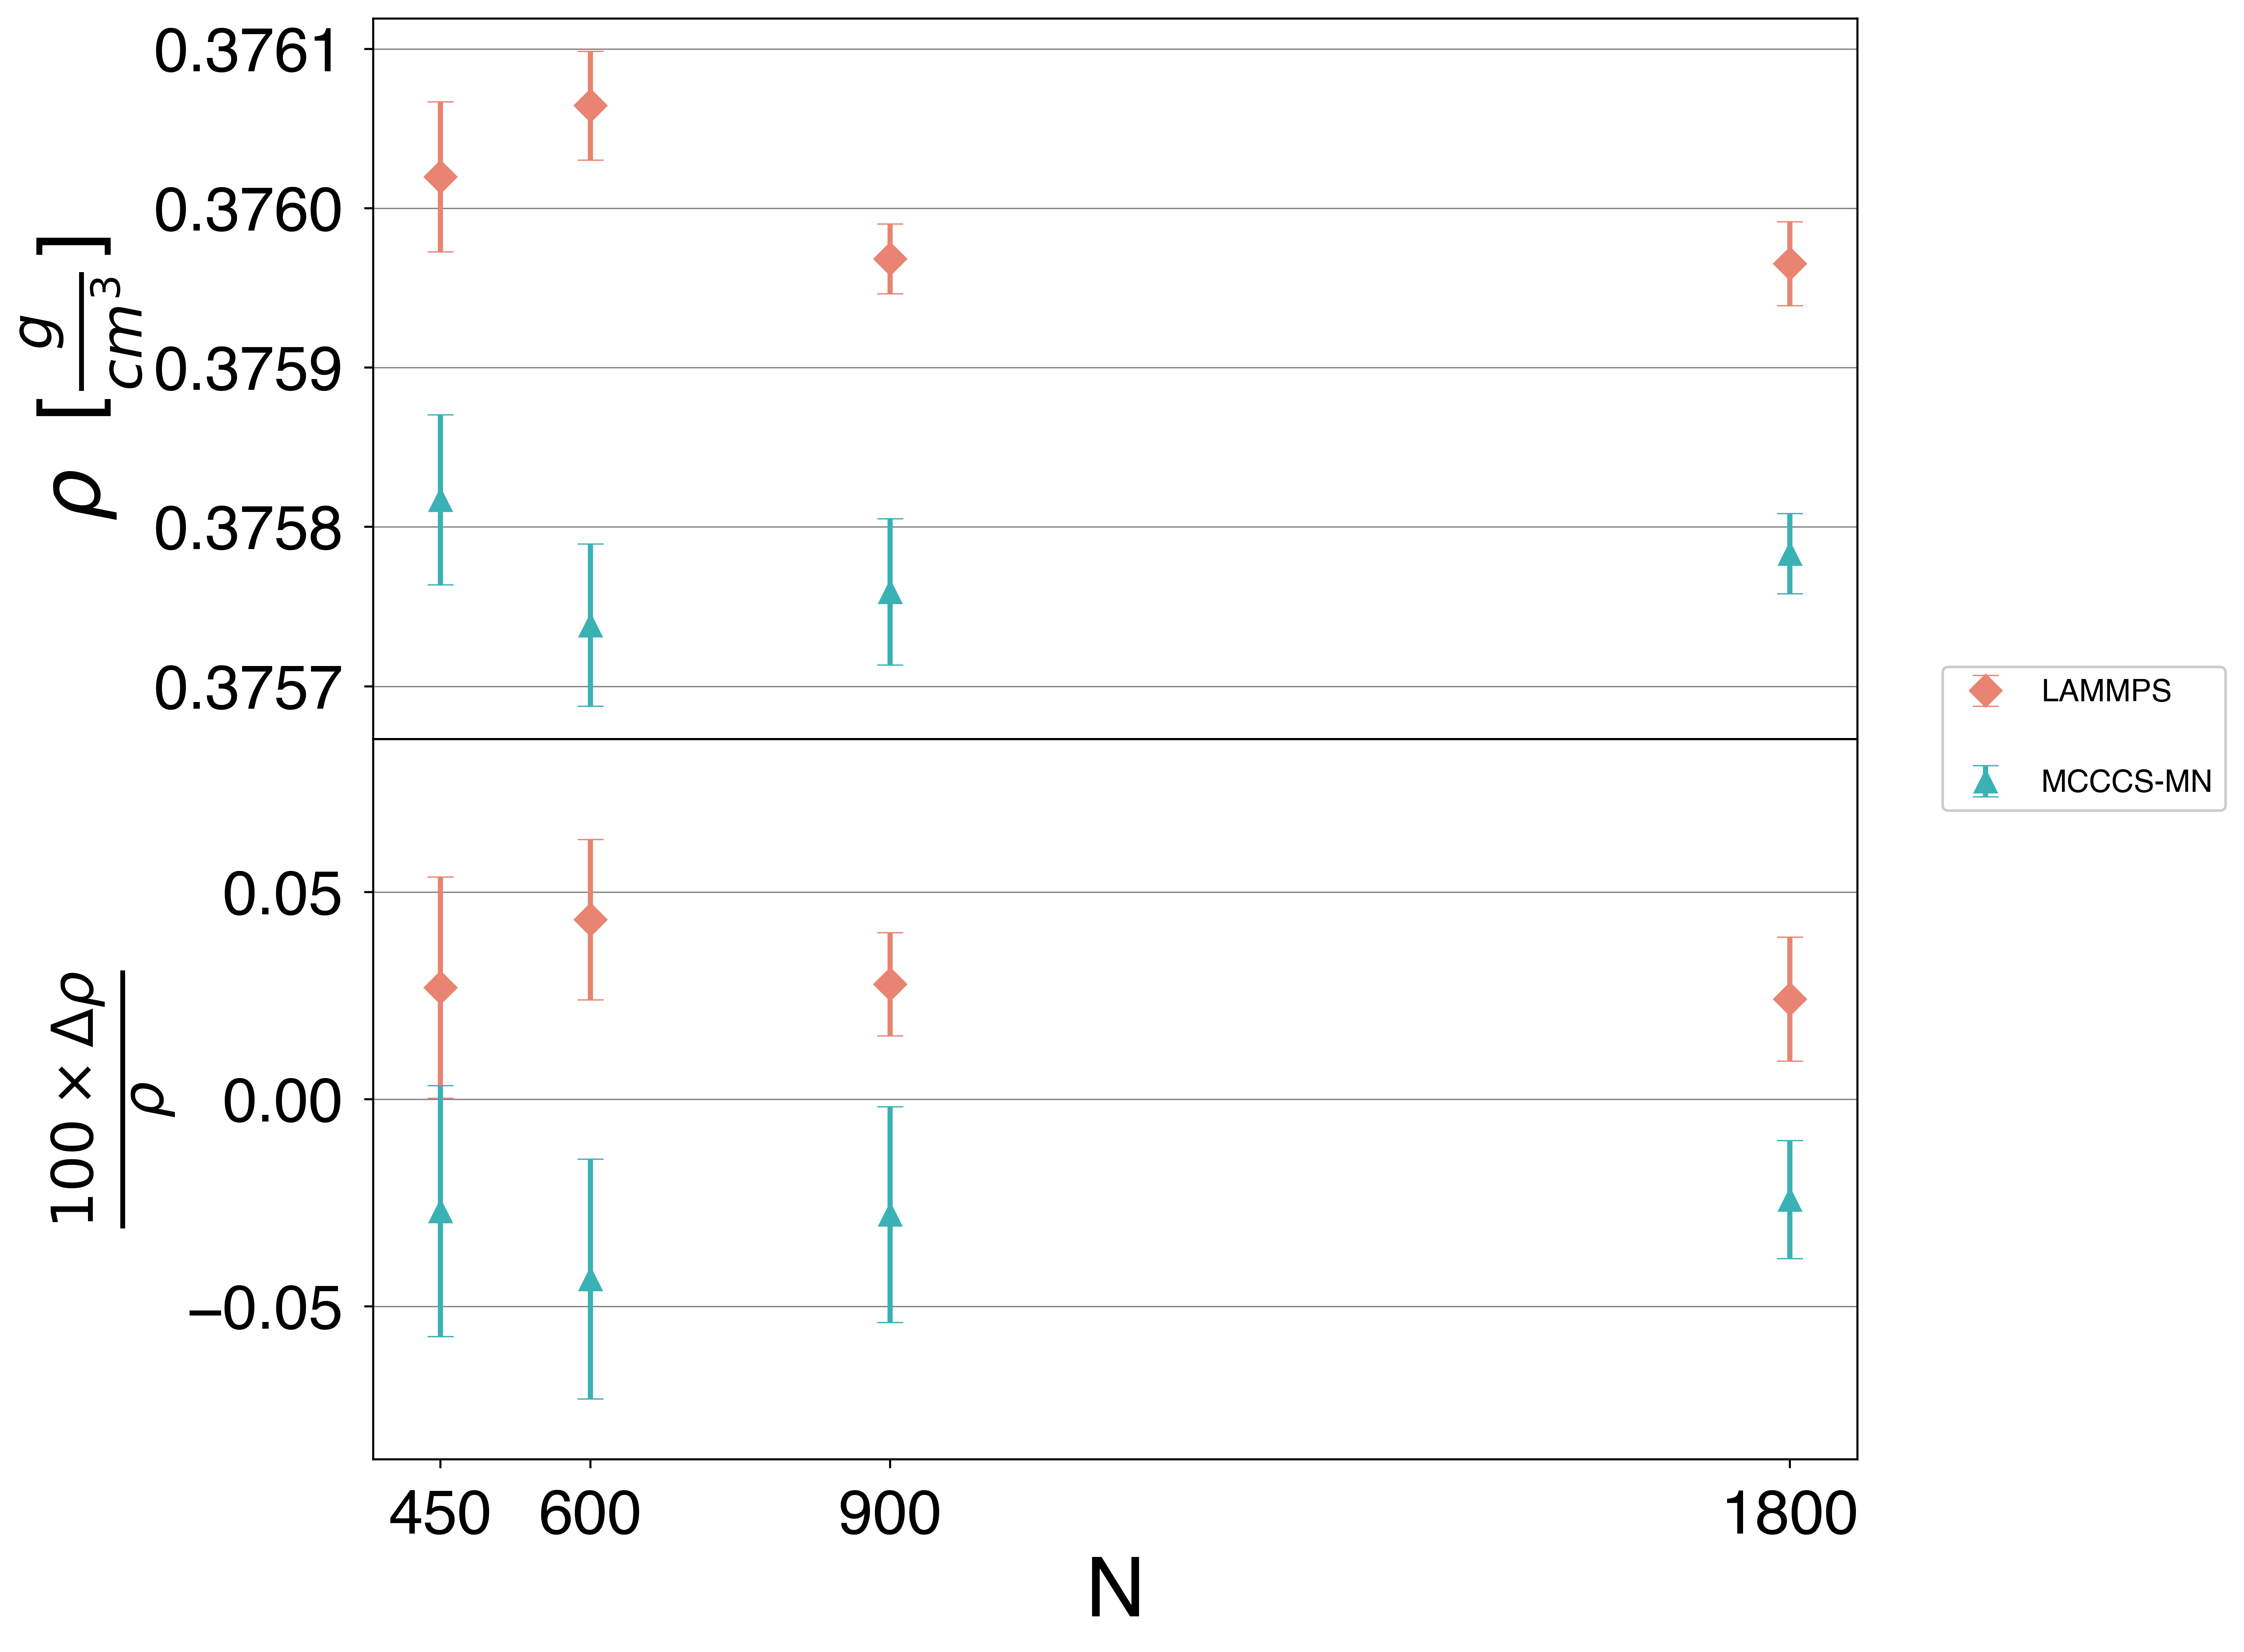

In [39]:
modfigsize = [12, 9]
create_stacked_density_deviation_plots(molecule_set, engines, modfigsize)
